In [7]:
import re
import os
import pandas as pd
import numpy as np
import torch
from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.image import imread
from io import StringIO
from sklearn.preprocessing import MultiLabelBinarizer
from torch.utils.data import Dataset, DataLoader ,random_split
from torchvision import datasets ,models , transforms
from pathlib import Path
import torchvision
from PIL import Image
import torchvision.models as models
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from tqdm import trange
from sklearn.metrics import precision_score,f1_score

In [8]:
drive.mount('/content/gdrive/',force_remount=True)

Mounted at /content/gdrive/


## Load the input data

In [3]:
# path to given dataset
path = '/content/gdrive/My Drive/COMP5329_Assignment/Dataset/'
folder = path + 'data/'

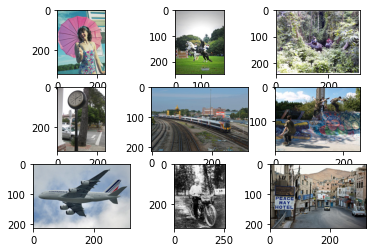

In [ ]:
# plot the first 9 images in the dataset
for i in range(9):
    plt.subplot(330 + 1 + i)
    filename = folder + str(i) + '.jpg'
    image = imread(filename)
    plt.imshow(image)

# show the figure
plt.show()

In [12]:
# Read Image data
train = pd.read_csv('/content/gdrive/MyDrive/COMP5329_Assignment_2/COMP5329S1A2Dataset/train.csv')
train.head()

,ImageID,Labels,Caption
0,0.jpg,1,Woman in swim suit holding parasol on sunny day.
1,1.jpg,1 19,A couple of men riding horses on top of a gree...
2,2.jpg,1,They are brave for riding in the jungle on tho...
3,3.jpg,8 3 13,a black and silver clock tower at an intersect...
4,4.jpg,8 3 7,A train coming to a stop on the tracks out side.


## Convert to One-Hot Encoding

In [ ]:
train['Labels_to_be_deleted']= train['Labels'].replace(' ',',', regex=True).astype(str)
transformed_labels = train['Labels'].apply(lambda x: pd.Series(x.split(' ')))
non_null_labels = transformed_labels.fillna('').values

one_hot = MultiLabelBinarizer()

labels_dataframe=pd.DataFrame(one_hot.fit_transform(non_null_labels))
labels_dataframe.columns=one_hot.classes_
labels_dataframe.drop('', axis=1, inplace=True) 
labels_dataframe['ColumnA'] = labels_dataframe[labels_dataframe.columns[:]].apply(
    lambda x: ','.join(x.dropna().astype(str)),
    axis=1
)

train['Labels']=labels_dataframe['ColumnA']
# Drop the extra column added above
train = train.drop(['Labels_to_be_deleted'], axis = 1)
train.head()


,ImageID,Labels,Caption
0,0.jpg,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",Woman in swim suit holding parasol on sunny day.
1,1.jpg,"1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0",A couple of men riding horses on top of a gree...
2,2.jpg,"1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0",They are brave for riding in the jungle on tho...
3,3.jpg,"0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0",a black and silver clock tower at an intersect...
4,4.jpg,"0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0",A train coming to a stop on the tracks out side.


## Normalise the Data

In [ ]:
class MyDataset(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None):    
    self.df = csv_file
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,index):
    d = self.df.iloc[index]
    image_path = os.path.join(folder, d.ImageID)
    image = Image.open(image_path).convert("RGB")
    
    label = d.Labels.split(',')
    labels = np.array(label).astype(np.float32)

    
    if self.transforms is not None:
      image = self.transforms(image)
    
    return image,labels.astype(float)
  
  def __len__(self):
    return len(self.df)

In [ ]:
batch_size=16

# Data Transformations
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

dataset = MyDataset(train, Path(folder) , transform)
validation_size = int(len(dataset)*0.2) 
trainset ,valset  = random_split( dataset , [len(dataset) -validation_size  ,validation_size])
print(f"length of training set: {len(trainset)} length of validation set: {len(valset)}")
dataloader = {"train":DataLoader(trainset , shuffle=False , batch_size=batch_size),
              "val": DataLoader(valset , shuffle=False , batch_size=batch_size)}

length of training set: 24000 length of validation set: 6000


## Dislay Normalised Image 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


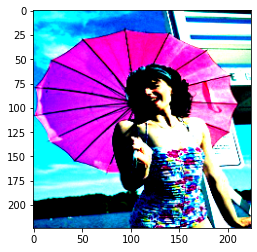

In [ ]:
plt.imshow(torchvision.utils.make_grid(dataset[0][0]).permute(1, 2, 0))

## Model

In [ ]:
# load the pretrained ResNet50 model
model = models.resnet50(pretrained=True)

## Transfer Learning

In [ ]:
def transfer_learning(number_of_features , number_of_classes ,dropout_prob=0.2 ,activation_func =nn.ReLU):
  feature_list = [number_of_features , number_of_features//2 , number_of_features//4]
  layers = []
  for in_f ,out_f in zip(feature_list[:-1] , feature_list[1:]):
    layers.append(nn.Linear(in_f , out_f))
    layers.append(activation_func())
    if dropout_prob !=0 : layers.append(nn.Dropout(dropout_prob))
    layers.append(nn.BatchNorm1d(out_f))
    
  layers.append(nn.Linear(feature_list[-1] , number_of_classes))
  return nn.Sequential(*layers)

In [ ]:
# Number of features in the last Linear unit
number_of_features = model.fc.in_features 
print(number_of_features)

# freeze the entire convolution base
for param in model.parameters():
  param.requires_grad_(False)

2048


In [ ]:
top_head = transfer_learning(num_features , len(one_hot.classes_)-1)

# replace the fully connected layer
model.fc = top_head 
print(top_head)

Sequential(
  (0): Linear(in_features=2048, out_features=1024, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.2, inplace=False)
  (3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (4): Linear(in_features=1024, out_features=512, bias=True)
  (5): ReLU()
  (6): Dropout(p=0.2, inplace=False)
  (7): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (8): Linear(in_features=512, out_features=18, bias=True)
)


In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
criterion = nn.BCEWithLogitsLoss()

# Choose optimizer
optimizer = optim.SGD(model.parameters(), lr=0.01)
sgdr_partial = lr_scheduler.CosineAnnealingLR(optimizer, T_max=5, eta_min=0.005 )

In [ ]:
def train(model , data_loader , criterion , optimizer ,scheduler, num_epochs=5):

  for epoch in trange(num_epochs,desc="Epochs"):
    result = []
    for phase in ['train', 'val']:
      if phase=="train":     # put the model in training mode
        model.train()
        # scheduler.step()
      else:     # put the model in validation mode
        model.eval()
       
      # keep track of training and validation loss
      running_loss = 0.0
      running_corrects = 0.0  
      
      for data , target in data_loader[phase]:
        #load the data and target to GPU
        data , target = data.to(device)  , target.to(device)
 
        with torch.set_grad_enabled(phase=="train"):
          if phase=="train"  :
            # zero the grad to stop it from accumulating
            optimizer.zero_grad()

          #feed the input
          output = model(data)
          #calculate the loss
          loss = criterion(output,target)
          preds = torch.sigmoid(output).data > 0.5
          # add weights?
          preds = preds.to(torch.float32)
          
          if phase=="train"  :
            # backward pass: compute gradient of the loss with respect to model parameters 
            loss.backward()
            # update the model parameters
            optimizer.step()          
            scheduler.step()


        # statistics
        running_loss += loss.item() * data.size(0)
        running_corrects += f1_score(target.to("cpu").to(torch.int).numpy() ,preds.to("cpu").to(torch.int).numpy() , average="samples")  * data.size(0)
        
        
      epoch_loss = running_loss / len(data_loader[phase].dataset)
      epoch_acc = running_corrects / len(data_loader[phase].dataset)

      result.append('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
    print(result)

In [ ]:
train(model, dataloader , criterion, optimizer,sgdr_partial,num_epochs=20)


Epochs:   5%|▌         | 1/20 [2:07:25<40:21:08, 7645.72s/it]

['train Loss: 0.6177 Acc: 0.2848', 'val Loss: 0.5128 Acc: 0.5300']



Epochs:  10%|█         | 2/20 [2:11:16<27:06:24, 5421.37s/it]

['train Loss: 0.4355 Acc: 0.5659', 'val Loss: 0.3247 Acc: 0.7357']



Epochs:  15%|█▌        | 3/20 [2:15:06<18:14:44, 3863.79s/it]

['train Loss: 0.2667 Acc: 0.7162', 'val Loss: 0.1983 Acc: 0.7602']



Epochs:  20%|██        | 4/20 [2:18:55<12:19:35, 2773.48s/it]

['train Loss: 0.1791 Acc: 0.7271', 'val Loss: 0.1471 Acc: 0.7669']



Epochs:  25%|██▌       | 5/20 [2:22:43<8:22:27, 2009.84s/it] 

['train Loss: 0.1459 Acc: 0.7346', 'val Loss: 0.1272 Acc: 0.7762']



Epochs:  30%|███       | 6/20 [2:26:31<5:44:11, 1475.08s/it]

['train Loss: 0.1312 Acc: 0.7429', 'val Loss: 0.1188 Acc: 0.7800']



Epochs:  35%|███▌      | 7/20 [2:30:17<3:58:27, 1100.55s/it]

['train Loss: 0.1231 Acc: 0.7497', 'val Loss: 0.1148 Acc: 0.7844']



Epochs:  40%|████      | 8/20 [2:34:04<2:47:39, 838.29s/it] 

['train Loss: 0.1184 Acc: 0.7561', 'val Loss: 0.1111 Acc: 0.7879']



Epochs:  45%|████▌     | 9/20 [2:37:50<2:00:02, 654.75s/it]

['train Loss: 0.1144 Acc: 0.7635', 'val Loss: 0.1088 Acc: 0.7915']



Epochs:  50%|█████     | 10/20 [2:41:36<1:27:41, 526.19s/it]

['train Loss: 0.1120 Acc: 0.7659', 'val Loss: 0.1077 Acc: 0.7950']



Epochs:  55%|█████▌    | 11/20 [2:45:25<1:05:32, 437.00s/it]

['train Loss: 0.1097 Acc: 0.7710', 'val Loss: 0.1069 Acc: 0.7942']



Epochs:  60%|██████    | 12/20 [2:49:13<49:52, 374.10s/it]  

['train Loss: 0.1074 Acc: 0.7758', 'val Loss: 0.1069 Acc: 0.7976']



Epochs:  65%|██████▌   | 13/20 [2:52:59<38:29, 329.93s/it]

['train Loss: 0.1059 Acc: 0.7801', 'val Loss: 0.1052 Acc: 0.7983']



Epochs:  70%|███████   | 14/20 [2:56:49<29:59, 299.88s/it]

['train Loss: 0.1041 Acc: 0.7828', 'val Loss: 0.1052 Acc: 0.7981']



Epochs:  75%|███████▌  | 15/20 [3:00:39<23:14, 278.94s/it]

['train Loss: 0.1028 Acc: 0.7854', 'val Loss: 0.1069 Acc: 0.7995']



Epochs:  80%|████████  | 16/20 [3:04:29<17:36, 264.24s/it]

['train Loss: 0.1016 Acc: 0.7878', 'val Loss: 0.1054 Acc: 0.8013']



Epochs:  85%|████████▌ | 17/20 [3:08:18<12:41, 253.76s/it]

['train Loss: 0.1006 Acc: 0.7899', 'val Loss: 0.1053 Acc: 0.8033']



Epochs:  90%|█████████ | 18/20 [3:12:06<08:11, 245.83s/it]

['train Loss: 0.0992 Acc: 0.7933', 'val Loss: 0.1063 Acc: 0.8025']



Epochs:  95%|█████████▌| 19/20 [3:15:53<04:00, 240.20s/it]

['train Loss: 0.0988 Acc: 0.7949', 'val Loss: 0.1060 Acc: 0.8013']



Epochs: 100%|██████████| 20/20 [3:19:40<00:00, 599.04s/it]

['train Loss: 0.0979 Acc: 0.7960', 'val Loss: 0.1068 Acc: 0.8017']


## Save trained Model

In [ ]:
def save_model(filename=Path("/content/gdrive/My Drive/Colab Notebooks/Res50_LR_001_SGD_20.pt")):
  # Save state of the model
  checkpoint = {'model_state_dict': model.state_dict(),}
  torch.save(checkpoint , filename)

save_model()

## Load Trained Model

In [ ]:
# Note this model might not be accessible to everyone
checkpoint= torch.load("/content/gdrive/My Drive/COMP5329_Assignment_2/Res50_LR_001_SGD_20.pt")
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
for param in model.parameters():
  param.requires_grad_(False)
top_head = transfer_learning(num_features , len(one_hot.classes_)-1)
model.fc = top_head 
model.load_state_dict(checkpoint['model_state_dict'])

## Test

In [ ]:
class MyDatasetTest(Dataset):
  def __init__(self , csv_file , img_dir , transforms=None):
    self.df = csv_file
    self.img_dir = img_dir
    self.transforms = transforms
    
  def __getitem__(self,idx):
    d = self.df.iloc[idx]
    img_path = os.path.join(folder, d.ImageID)
    image = Image.open(img_path).convert("RGB")
    if self.transforms is not None:
      image = self.transforms(image)
    return image
  
  def __len__(self):
    return len(self.df)

In [ ]:
FILENAME = path + 'test.csv'

with open(FILENAME) as file:
    lines = [re.sub(r'([^,])"(\s*[^\n])', r'\1/"\2', line) for line in file]

test = pd.read_csv(StringIO(''.join(lines)), escapechar="/")

In [ ]:
batch_size=16
transform = transforms.Compose([transforms.Resize((224,224)) , 
                               transforms.ToTensor(),
                               transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                               ])

datatest = MyDatasetTest(test, Path(folder) , transform)
print(f"testset len {len(datatest)}")
# testloader = {"test":DataLoader(trainset , shuffle=True , batch_size=batch_size)}
testloader = DataLoader(datatest , shuffle=False , batch_size=batch_size)

testset len 10000


In [ ]:
# Remove the empty class in the one hot encoding
one_hot.classes_=np.delete(one_hot.classes_,0)
one_hot.classes_

array(['1', '10', '11', '13', '14', '15', '16', '17', '18', '19', '2',
       '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
model.eval()

ids_all = []
predictions = []

for image in testloader:
  test_image = image.to(device)
  with torch.set_grad_enabled(False):
    output = model(test_image)
    preds = torch.sigmoid(output).data > 0.5
    preds = preds.to("cpu").to(torch.int).numpy()
    predictions.append(one_hot.inverse_transform(preds))
        
print("Done making predictions!")

Done making predictions!


In [ ]:
final_predicted_list=[]
for prediction_batch in predictions:
  for prediction in prediction_batch:
    final_predicted_list.append(' '.join(prediction))
    
submissions = pd.DataFrame({
    "ImageID": test['ImageID'],
    "Labels": final_predicted_list
})

In [ ]:
submissions.head()

,ImageID,Labels
0,30000.jpg,1
1,30001.jpg,1 3
2,30002.jpg,1
3,30003.jpg,1
4,30004.jpg,1


In [ ]:
submissions.to_csv("/content/gdrive/My Drive/Colab Notebooks/res50_sgd_LR001_e20.csv", index=False)